In [128]:
# !rm -rf ./utils
# !git clone https://github.com/emiliodelgadouy/utils.git --quiet
# !pip install comet_ml --quiet
# !pip install optuna --quiet
# !pip install --no-cache-dir -U crcmod --quiet

from tensorflow.keras import mixed_precision
import optuna

mixed_precision.set_global_policy("mixed_float16")

import numpy as np
import tensorflow as tf
from utils.Dataset import Dataset
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import preprocess_input
import tensorflow_addons as tfa


gpus = tf.config.list_physical_devices('GPU')
# from google.colab import auth
# auth.authenticate_user()
# !gsutil cp gs://helen-data/dumps/ds_balanced.npz ./
AUTOTUNE = tf.data.AUTOTUNE
print("✅ Env ready!")
print("✅ GPU avilable" if tf.config.list_physical_devices("GPU") else "❌ NO GPU avilable")
print(AUTOTUNE)


✅ Env ready!
❌ NO GPU avilable
-1


In [129]:
import tensorflow as tf
import keras
# import tensorflow_addons as tfa

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
# print("TensorFlow Addons:", tfa.__version__)

TensorFlow: 2.15.1
Keras: 2.15.0


In [130]:
dataset = Dataset(lateralize_images=True, dataset_csv="./ds_balanced.csv")
full_train = dataset[(dataset["split"] == "training")]
ds_test = dataset[(dataset["split"] == "test")]
ds_train, ds_val = train_test_split(
    full_train,
    test_size=0.20,
    random_state=42,
    stratify=full_train["findings"]
)

IMG_SIZE = (299, 299)
# IMG_SIZE = (500, 500)
BATCH_SIZE = 1
EPOCHS = 1

labels_train_np = ds_train["findings"].astype("int64").to_numpy()
classes = np.unique(labels_train_np)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=labels_train_np)
cw = {int(c): float(w) for c, w in zip(classes, weights)}

keys = tf.constant(list(cw.keys()), dtype=tf.int64)  # 👈 claves int64
vals = tf.constant(list(cw.values()), dtype=tf.float32)

class_weight_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, vals),
    default_value=tf.constant(1.0, tf.float32)
)



In [131]:
# ==== IMPORTS Y CONFIG ====
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE
# Debes tener definidas: IMG_SIZE = (H, W) y BATCH_SIZE, y class_weight_table


# ==== NORMALIZACIÓN Y AUGMENT ====
def zscore_norm(img):
    mean, var = tf.nn.moments(img, axes=[0, 1, 2], keepdims=True)
    std = tf.sqrt(var)
    return (img - mean) / (std + 1e-6)

def _augment(img):
    # Rotación aleatoria (±10°)
    angle = tf.random.uniform([], -10, 10) * np.pi / 180.0
    img = tfa.image.rotate(img, angle, interpolation='BILINEAR')

    # Zoom aleatorio (crop + resize)
    zoom_scale = tf.random.uniform([], 0.9, 1.1)  # 90%–110%
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    new_h = tf.cast(tf.cast(h, tf.float32) * zoom_scale, tf.int32)
    new_w = tf.cast(tf.cast(w, tf.float32) * zoom_scale, tf.int32)
    img = tf.image.resize(img, (new_h, new_w))
    img = tf.image.resize_with_crop_or_pad(img, h, w)

    # Brillo / contraste
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # Clampeo a [0,1] para que las aug trabajen con intensidades válidas
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

def _preprocess_and_weight(img, label):
    # z-score SIEMPRE después de augment
    # x = zscore_norm(img)
    y = tf.cast(label, tf.float32)

    y_int = tf.cast(label, tf.int64)
    sw = class_weight_table.lookup(y_int)
    return img, y, sw


# ==== HELPERS ROI/CROP ====
def _safe_float_col(df, name):
    if name in df.columns:
        return df[name].astype("float32").to_numpy()
    return np.full((len(df),), np.nan, dtype="float32")

def _build_slices(df):
    paths = df["path"].astype(str).to_numpy()
    labels = df["findings"].astype("float32").to_numpy()
    later  = df["laterality"].astype(str).to_numpy() if "laterality" in df.columns else np.array([""] * len(df))
    xmin = _safe_float_col(df, "xmin")
    ymin = _safe_float_col(df, "ymin")
    xmax = _safe_float_col(df, "xmax")
    ymax = _safe_float_col(df, "ymax")
    return paths, labels, later, xmin, ymin, xmax, ymax

def _center_crop(img, target_hw):
    th, tw = target_hw[0], target_hw[1]
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para crop")
    tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para crop")
    y0 = tf.maximum(0, (h - th) // 2); x0 = tf.maximum(0, (w - tw) // 2)
    y0 = tf.minimum(y0, h - th); x0 = tf.minimum(x0, w - tw)
    return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

def _center_crop_on_point(img, cx, cy, target_hw):
    th, tw = target_hw[0], target_hw[1]
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para crop")
    tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para crop")
    y0 = tf.cast(tf.round(cy - tf.cast(th, tf.float32) / 2.0), tf.int32)
    x0 = tf.cast(tf.round(cx - tf.cast(tw, tf.float32) / 2.0), tf.int32)
    y0 = tf.clip_by_value(y0, 0, h - th); x0 = tf.clip_by_value(x0, 0, w - tw)
    return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

def _maybe_flip_left_right(img, lat_str):
    lat = tf.strings.upper(lat_str)
    is_right = tf.strings.regex_full_match(lat, r"(R(IGHT)?)|(.*-R$)|(^R-.*)")
    return is_right, tf.cond(is_right, lambda: tf.image.flip_left_right(img), lambda: img)

def _flip_roi_if_needed(is_right, img, xmin, ymin, xmax, ymax):
    w = tf.shape(img)[1]
    def _flip():
        x_min2 = tf.cast(w - 1, tf.float32) - xmax
        x_max2 = tf.cast(w - 1, tf.float32) - xmin
        return x_min2, ymin, x_max2, ymax
    def _same():
        return xmin, ymin, xmax, ymax
    return tf.cond(is_right, _flip, _same)

def _roi_valid(xmin, ymin, xmax, ymax):
    return (
        tf.math.is_finite(xmin) & tf.math.is_finite(ymin) &
        tf.math.is_finite(xmax) & tf.math.is_finite(ymax) &
        (xmax > xmin) & (ymax > ymin)
    )

def _draw_bb(img, xmin, ymin, xmax, ymax):
    """Dibuja BB roja (si es válida) en img; coords absolutas píxel."""
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    ymin_n = ymin / tf.cast(h, tf.float32)
    xmin_n = xmin / tf.cast(w, tf.float32)
    ymax_n = ymax / tf.cast(h, tf.float32)
    xmax_n = xmax / tf.cast(w, tf.float32)
    boxes = tf.stack([ymin_n, xmin_n, ymax_n, xmax_n])[tf.newaxis, tf.newaxis, :]
    return tf.image.draw_bounding_boxes(img[tf.newaxis], boxes, colors=[[1.0, 0.0, 0.0]])[0]


# ==== LOAD + MAPS ====
def _load_roi(path, label, lat, xmin, ymin, xmax, ymax):
    bytes_ = tf.io.read_file(path)
    img = tf.io.decode_image(bytes_, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]

    # Flip horizontal si lateridad derecha y espejar ROI
    is_right, img = _maybe_flip_left_right(img, lat)
    # xmin, ymin, xmax, ymax = _flip_roi_if_needed(is_right, img, xmin, ymin, xmax, ymax)

    return img, label, xmin, ymin, xmax, ymax

def _train_map_roi(img, label, xmin, ymin, xmax, ymax):
    target = tf.constant(IMG_SIZE, tf.int32)  # (H, W)
    th, tw = target[0], target[1]

    pos = tf.equal(tf.cast(label, tf.int32), 1)
    valid = _roi_valid(xmin, ymin, xmax, ymax)

    def _pos_branch():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]

        # Centro ROI (o centro imagen si ROI inválido)
        cx = tf.where(valid, (xmin + xmax) / 2.0, tf.cast(w, tf.float32) / 2.0)
        cy = tf.where(valid, (ymin + ymax) / 2.0, tf.cast(h, tf.float32) / 2.0)

        # Jitter relativo al tamaño del ROI (±40%)
        roi_w = tf.where(valid, xmax - xmin, tf.cast(w, tf.float32))
        roi_h = tf.where(valid, ymax - ymin, tf.cast(h, tf.float32))
        jitter_x = tf.random.uniform([], -0.4, 0.4, dtype=tf.float32) * roi_w
        jitter_y = tf.random.uniform([], -0.4, 0.4, dtype=tf.float32) * roi_h
        cx_jit = cx + jitter_x; cy_jit = cy + jitter_y

        # BB solo en positivos
        # img_bb = tf.cond(
        #     valid,
        #     lambda: _draw_bb(img, xmin, ymin, xmax, ymax),
        #     lambda: img
        # )

        out = _center_crop_on_point(img, cx_jit, cy_jit, target)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    def _neg_branch():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para random crop")
        tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para random crop")
        y0 = tf.random.uniform((), 0, h - th + 1, dtype=tf.int32)
        x0 = tf.random.uniform((), 0, w - tw + 1, dtype=tf.int32)
        out = tf.image.crop_to_bounding_box(img, y0, x0, th, tw)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    img2 = tf.cond(pos, _pos_branch, _neg_branch)
    return img2, label

def _eval_map_roi(img, label, xmin, ymin, xmax, ymax):
    target = tf.constant(IMG_SIZE, tf.int32)
    pos = tf.equal(tf.cast(label, tf.int32), 1)
    valid = _roi_valid(xmin, ymin, xmax, ymax)

    def _pos():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        cx = tf.where(valid, (xmin + xmax) / 2.0, tf.cast(w, tf.float32) / 2.0)
        cy = tf.where(valid, (ymin + ymax) / 2.0, tf.cast(h, tf.float32) / 2.0)
        out = _center_crop_on_point(img, cx, cy, target)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    def _neg():
        return _center_crop(img, target)

    img2 = tf.cond(pos, _pos, _neg)
    return img2, label


# ==== DATASET BUILDER ====
def make_ds(df, training: bool, shuffle=False):
    paths, labels, later, xmin, ymin, xmax, ymax = _build_slices(df)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels, later, xmin, ymin, xmax, ymax))
    if shuffle:
        ds = ds.shuffle(min(8192, len(df)), reshuffle_each_iteration=True)

    ds = ds.map(_load_roi, num_parallel_calls=AUTOTUNE)
    ds = ds.map(_train_map_roi if training else _eval_map_roi, num_parallel_calls=AUTOTUNE)

    if training:
        # Augment SOLO en train y antes de z-score
        ds = ds.map(lambda img, lbl: (_augment(img), lbl), num_parallel_calls=AUTOTUNE)

    ds = ds.map(_preprocess_and_weight, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)

    opts = tf.data.Options()
    opts.experimental_deterministic = False
    return ds.with_options(opts)


# ==== EJEMPLO DE USO ====
train_ds = make_ds(ds_train, training=True,  shuffle=True)
val_ds   = make_ds(ds_val,   training=False, shuffle=False)
test_ds  = make_ds(ds_test,  training=False, shuffle=False)


In [132]:
# val_ds   = make_ds(ds_val,   training=False)
# test_ds  = make_ds(ds_test,  training=False)

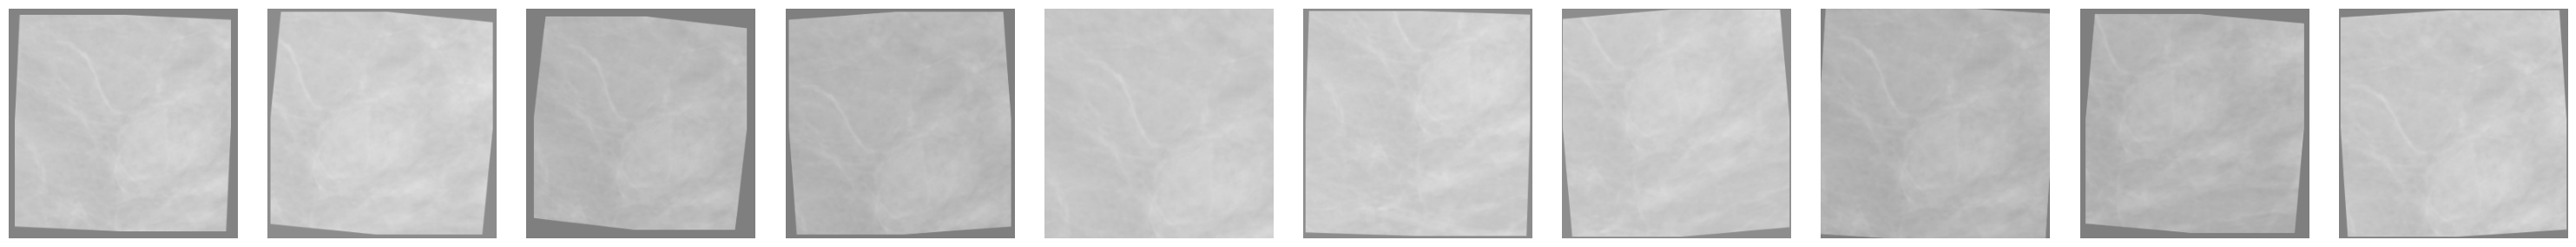

In [133]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Dataset fijo con 10 imágenes positivas
explore_ds = make_ds(
    ds_train[ds_train["findings"] == 1].head(1),
    training=True,
    shuffle=False
)

N_AUGS = 10  # cuántas veces muestro cada imagen

# Convertimos el dataset a lista para poder iterar de forma estable
explore_list = list(explore_ds.unbatch().as_numpy_iterator())

# Crear figura: 10 filas (imágenes) × N_AUGS columnas (augmentations)
fig, axes = plt.subplots(len(explore_list), N_AUGS, figsize=(3 * N_AUGS, 3 * len(explore_list)))

for i, (img, lbl, _) in enumerate(explore_list):
    for j in range(N_AUGS):
        # Para obtener un augment distinto, volvemos a pasar el mismo path
        # recreando un dataset con UN solo elemento
        one_df = ds_train[ds_train["findings"] == 1].iloc[[i]]
        one_ds = make_ds(one_df, training=True, shuffle=False)

        aug_img, aug_lbl, _ = next(iter(one_ds))
        aug_img = (aug_img[0].numpy() + 1) / 2.0

        ax = axes[i, j] if len(explore_list) > 1 else axes[j]
        ax.imshow(aug_img)
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(f"Img {i} (Label={lbl:.0f})", fontsize=10)

plt.tight_layout()
plt.show()


In [134]:
import os, gc, time, random
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir="./logs/fit", histogram_freq=1, profile_batch='1,5' )

def build_model(l2_reg, dropout_rate, unfreeze_pct):
    base = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    for l in base.layers:
        l.trainable = False
    n_total = len(base.layers)
    n_unfreeze = int(n_total * unfreeze_pct)
    if n_unfreeze > 0:
        for l in base.layers[-n_unfreeze:]:
            l.trainable = True

    x = base.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    # salida en float32 para evitar underflow con mixed precision
    out = Dense(1, activation='sigmoid', dtype='float32')(x)
    return Model(inputs=base.input, outputs=out)
def objective(trial):
    # seeds
    random.seed(42); np.random.seed(42); tf.random.set_seed(42)

    # HPs
    lr          = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout     = trial.suggest_float('dropout_rate', 0.2, 0.6)
    l2_reg      = trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True)
    unfreeze_pc = trial.suggest_float("unfreeze_pct", 0.0, 0.3)

    model = build_model(l2_reg, dropout, unfreeze_pc)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc_roc', curve='ROC')])

    t0 = time.time()
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        # callbacks=[tensorboard_callback],
        verbose=1
    )
    elapsed = time.time() - t0

    # evaluar (usa sample_weight del dataset)
    loss, acc, auc = model.evaluate(test_ds, verbose=1)

    # limpieza
    del model
    tf.keras.backend.clear_session()
    gc.collect()

    # Optuna maximiza accuracy (mantenés tu criterio)
    return float(acc)

In [135]:
    study = optuna.create_study(
        direction="maximize",   # porque devolvés accuracy
        study_name="inceptionv3_tuning"
    )
    study.optimize(objective, n_trials=1)   # ajustá n_trials a lo que soporte tu GPU

    print("Mejores hiperparámetros encontrados:")
    print(study.best_trial.params)
    print("Mejor accuracy:", study.best_trial.value)

[I 2025-08-31 21:10:51,615] A new study created in memory with name: inceptionv3_tuning


  14/4534 [..............................] - ETA: 1:53:19 - loss: 3.1266 - accuracy: 0.6429 - auc_roc: 0.2444

[W 2025-08-31 21:11:26,544] Trial 0 failed with parameters: {'learning_rate': 0.00032752794787670197, 'dropout_rate': 0.4377133197651111, 'l2_reg': 1.5716180366852697e-06, 'unfreeze_pct': 0.18156112483470152} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/projects/tesis/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_77859/207909527.py", line 45, in objective
    model.fit(
  File "/opt/projects/tesis/.venv/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/opt/projects/tesis/.venv/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/projects/tesis/.venv/lib/python3.11/

KeyboardInterrupt: 